## Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models, layers, regularizers
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Load data

#### We use grayscale color mode since these are X-ray images. Binary class mode is used to distinguish between normal and pneumonia images.

In [2]:
train_data_dir = 'ZhangLabData/CellData/chest_xray/train'
test_data_dir = 'ZhangLabData/CellData/chest_xray/test'

#Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
       test_data_dir, 
       target_size=(64, 64), batch_size=132, color_mode='grayscale', class_mode='binary')

#Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
       train_data_dir, 
       target_size=(64, 64), batch_size=790, color_mode='grayscale', class_mode='binary')

#Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [3]:
print(train_labels[:10])

[1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]


## PREPROCESSING
#### Create validation set from training set

In [4]:
X = train_images
y = train_labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [5]:
train_images.shape

(790, 64, 64, 1)

#### Preview images (Normal)

In [6]:
print('X_train shape: ',np.shape(X_train))
print('y_train shape: ',np.shape(y_train))
print('X_val shape: ',np.shape(X_val))
print('y_val shape: ',np.shape(y_val))

X_train shape:  (632, 64, 64, 1)
y_train shape:  (632,)
X_val shape:  (158, 64, 64, 1)
y_val shape:  (158,)


In [7]:
test_images.shape

(132, 64, 64, 1)

#### Reshape  images

In [8]:
#train set
X_train_unrow = X_train.reshape(632, -1)
X_train_unrow.shape

(632, 4096)

In [9]:
#test set
X_val_unrow = X_val.reshape(158, -1)
X_val_unrow.shape

(158, 4096)

#### Labels for images

In [10]:
y_train[:10]

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [11]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

#### Scale data and validate shapes

In [12]:
#scaling the data
X_train_img_final = X_train_unrow/255
X_val_img_final = X_val_unrow/255

type(X_val_img_final)

numpy.ndarray

In [13]:
print(X_train_img_final.shape)
print(X_val_img_final.shape)

(632, 4096)
(158, 4096)


## Model creation
#### We will use recall as our metric, as we're more concerned about false negatives than false positives.

#### Baseline Model with DummyClassifier

In [14]:
#dummy classifer/regressor for baseline
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_img_final, y_train)

DummyClassifier(strategy='most_frequent')

In [15]:
dummy.predict(X_val_img_final)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.], dtype=float32)

In [16]:
dummy.score(X_val_img_final, y_val)

0.810126582278481

#### Initial Neural Network Model Creation using tanh activation function

In [17]:
np.random.seed(42)
model = models.Sequential()
model.add(layers.Dense(63, activation='tanh', input_shape=(4096,)))
model.add(layers.Dense(42, activation='tanh'))
model.add(layers.Dense(21, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid')) #output layer, binary classification

In [18]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results = model.fit(X_train_img_final,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_img_final, y_val))

Epoch 1/50
20/20 [==============================] - 0s 15ms/step - loss: 0.5747 - recall: 0.9462 - acc: 0.7326 - val_loss: 0.4545 - val_recall: 1.0000 - val_acc: 0.8101
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5071 - recall: 0.9979 - acc: 0.7642 - val_loss: 0.4235 - val_recall: 1.0000 - val_acc: 0.8101
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4835 - recall: 0.9524 - acc: 0.7658 - val_loss: 0.3781 - val_recall: 1.0000 - val_acc: 0.8101
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4234 - recall: 0.9793 - acc: 0.7959 - val_loss: 0.6092 - val_recall: 0.6016 - val_acc: 0.6772
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4315 - recall: 0.9441 - acc: 0.8085 - val_loss: 0.4779 - val_recall: 1.0000 - val_acc: 0.8101
Epoch 6/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3821 - recall: 0.9503 - acc: 0.8307 - val_loss: 0.2780 - val_recall: 0.9688 - val_acc

20/20 [==============================] - 0s 2ms/step - loss: 0.1006 - recall: 0.9772 - acc: 0.9604 - val_loss: 0.1129 - val_recall: 0.9766 - val_acc: 0.9620
Epoch 50/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1764 - recall: 0.9648 - acc: 0.9383 - val_loss: 0.1157 - val_recall: 0.9609 - val_acc: 0.9494


#### Model evaluation

In [19]:
results_train = model.evaluate(X_train_img_final, y_train)

20/20 [==============================] - 0s 942us/step - loss: 0.0836 - recall: 0.9814 - acc: 0.9778


In [20]:
results_val = model.evaluate(X_val_img_final, y_val)

5/5 [==============================] - 0s 992us/step - loss: 0.1157 - recall: 0.9609 - acc: 0.9494


#### Create visualization function to plot epochs vs loss for training and test sets for each model created.

In [21]:
#plot epochs vs loss for train and test set
def visualize_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss v Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show();
    

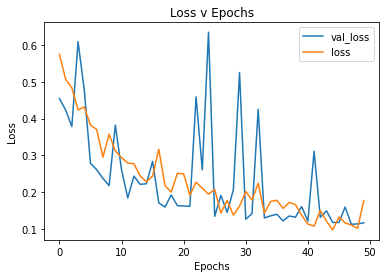

In [22]:
visualize_results(results)

In [23]:
label_pred = (model.predict(X_val_img_final) > 0.5).astype(int)

cf_matrix = confusion_matrix(y_val, label_pred)

<AxesSubplot:>

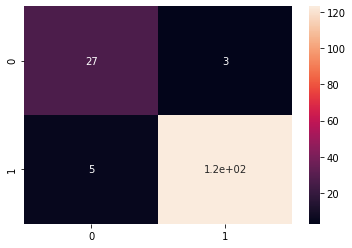

In [24]:
sns.heatmap(cf_matrix, annot=True)

#### Insight: according to the Loss plot, there is significant overfitting of the model due to the high variation of the validation curve. Any subsequent models must reduce the variance and overfitting of the first model, as well as have high recall and accuracy scores.


#### Will adding EarlyStopping improve the model?

In [25]:
#create new model with similar parameters
np.random.seed(42)
model2 = models.Sequential()
model2.add(layers.Dense(63, activation='tanh', input_shape=(4096,)))
model2.add(layers.Dense(42, activation='tanh'))
model2.add(layers.Dense(21, activation='tanh'))
model2.add(layers.Dense(1, activation='sigmoid')) #output layer, binary classification

In [26]:
#introduce earlystopping and modelcheckpoint 
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), ModelCheckpoint(filepath='best_model.h5',
                                                                                 monitor='val_loss', save_best_only=True)]

In [27]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results2 = model2.fit(X_train_img_final,
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_img_final, y_val))

Epoch 1/50
20/20 [==============================] - 0s 17ms/step - loss: 0.5508 - recall_1: 0.9524 - acc: 0.7326 - val_loss: 0.4552 - val_recall_1: 1.0000 - val_acc: 0.8101
Epoch 2/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4886 - recall_1: 1.0000 - acc: 0.7642 - val_loss: 0.4154 - val_recall_1: 1.0000 - val_acc: 0.8101
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.4664 - recall_1: 1.0000 - acc: 0.7674 - val_loss: 0.3718 - val_recall_1: 1.0000 - val_acc: 0.8101
Epoch 4/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4080 - recall_1: 0.9959 - acc: 0.7880 - val_loss: 0.3364 - val_recall_1: 1.0000 - val_acc: 0.8291
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4158 - recall_1: 0.9524 - acc: 0.7911 - val_loss: 0.3491 - val_recall_1: 1.0000 - val_acc: 0.8101
Epoch 6/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3425 - recall_1: 0.9834 - acc: 0.8465 - val_loss: 0.3877 - val_re

20/20 [==============================] - 0s 4ms/step - loss: 0.1225 - recall_1: 0.9689 - acc: 0.9541 - val_loss: 0.1182 - val_recall_1: 0.9766 - val_acc: 0.9620
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1267 - recall_1: 0.9689 - acc: 0.9589 - val_loss: 0.1292 - val_recall_1: 0.9609 - val_acc: 0.9494
Epoch 50/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0869 - recall_1: 0.9855 - acc: 0.9763 - val_loss: 0.2345 - val_recall_1: 1.0000 - val_acc: 0.9114


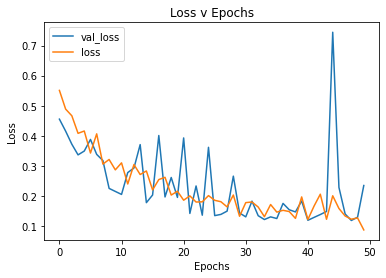

In [28]:
visualize_results(results2)

<AxesSubplot:>

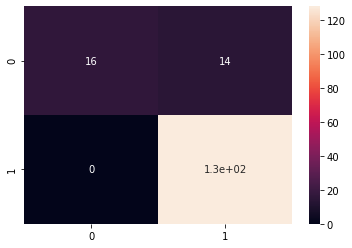

In [51]:
#accuracy is greater than 80%, visualize confusion matrix
label_pred = (model2.predict(X_val_img_final) > 0.5).astype(int)

cf_matrix = confusion_matrix(y_val, label_pred)

sns.heatmap(cf_matrix, annot=True)

#### Variation in val_loss is still very high. Additionally, overfitting issue still hasn't been resolved. Will build a CNN, then attempt to control overfitting.

In [29]:
#CNN model
np.random.seed(42)
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3,3), activation='tanh',
                        input_shape=(64, 64, 1)))

model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='tanh'))
model3.add(layers.Dense(42, activation='tanh'))
model3.add(layers.Dense(21, activation='tanh'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [30]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                7872576   
_________________________________________________________________
dense_9 (Dense)              (None, 42)                2730      
_________________________________________________________________
dense_10 (Dense)             (None, 21)                903       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 22        
Total params: 7,876,551
Trainable params: 7,876,551
Non-trainable params: 0
____________________________________________

In [31]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results3 = model3.fit(X_train, 
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 1s 59ms/step - loss: 0.5809 - recall_2: 0.9482 - acc: 0.7358 - val_loss: 0.4928 - val_recall_2: 1.0000 - val_acc: 0.8101
Epoch 2/50
20/20 [==============================] - 1s 57ms/step - loss: 0.5472 - recall_2: 1.0000 - acc: 0.7642 - val_loss: 0.4898 - val_recall_2: 1.0000 - val_acc: 0.8101
Epoch 3/50
20/20 [==============================] - 1s 44ms/step - loss: 0.5497 - recall_2: 1.0000 - acc: 0.7642 - val_loss: 0.4890 - val_recall_2: 1.0000 - val_acc: 0.8101
Epoch 4/50
20/20 [==============================] - 1s 46ms/step - loss: 0.5473 - recall_2: 1.0000 - acc: 0.7642 - val_loss: 0.4925 - val_recall_2: 1.0000 - val_acc: 0.8101
Epoch 5/50
20/20 [==============================] - 1s 47ms/step - loss: 0.5481 - recall_2: 1.0000 - acc: 0.7642 - val_loss: 0.4935 - val_recall_2: 1.0000 - val_acc: 0.8101
Epoch 6/50
20/20 [==============================] - 1s 46ms/step - loss: 0.5472 - recall_2: 1.0000 - acc: 0.7642 - val_loss: 0.4886 - v

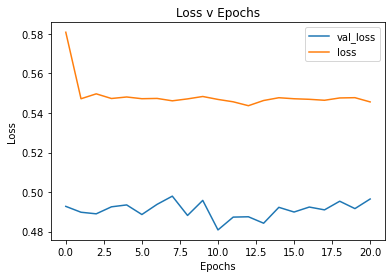

In [32]:
visualize_results(results3)

#### The variation has been reduced, but there is still overfitting. From here, we will attempt L2 regularization on the model.

#### L2 regularization with model3 structure

In [33]:
np.random.seed(42)

#introducing lambda coefficent for L2 regularization 
lambda_coeff = 0.005

model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3,3), activation='tanh',
                        input_shape=(64, 64, 1)))

model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
model4.add(layers.Dense(42, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
model4.add(layers.Dense(21, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
model4.add(layers.Dense(1, activation='sigmoid'))

In [34]:
model4.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results4 = model4.fit(X_train, 
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 2s 75ms/step - loss: 1.6346 - recall_3: 0.9462 - acc: 0.7326 - val_loss: 1.5149 - val_recall_3: 1.0000 - val_acc: 0.8101
Epoch 2/50
20/20 [==============================] - 1s 62ms/step - loss: 1.5742 - recall_3: 1.0000 - acc: 0.7642 - val_loss: 1.5181 - val_recall_3: 1.0000 - val_acc: 0.8101
Epoch 3/50
20/20 [==============================] - 1s 63ms/step - loss: 1.5703 - recall_3: 1.0000 - acc: 0.7642 - val_loss: 1.5127 - val_recall_3: 1.0000 - val_acc: 0.8101
Epoch 4/50
20/20 [==============================] - 1s 63ms/step - loss: 1.5669 - recall_3: 1.0000 - acc: 0.7642 - val_loss: 1.5113 - val_recall_3: 1.0000 - val_acc: 0.8101
Epoch 5/50
20/20 [==============================] - 1s 63ms/step - loss: 1.5627 - recall_3: 1.0000 - acc: 0.7642 - val_loss: 1.5070 - val_recall_3: 1.0000 - val_acc: 0.8101
Epoch 6/50
20/20 [==============================] - 1s 63ms/step - loss: 1.5587 - recall_3: 1.0000 - acc: 0.7642 - val_loss: 1.5024 - v

20/20 [==============================] - 1s 62ms/step - loss: 1.3947 - recall_3: 1.0000 - acc: 0.7642 - val_loss: 1.3362 - val_recall_3: 1.0000 - val_acc: 0.8101
Epoch 49/50
20/20 [==============================] - 1s 64ms/step - loss: 1.3922 - recall_3: 1.0000 - acc: 0.7642 - val_loss: 1.3272 - val_recall_3: 1.0000 - val_acc: 0.8101
Epoch 50/50
20/20 [==============================] - 1s 63ms/step - loss: 1.3789 - recall_3: 1.0000 - acc: 0.7642 - val_loss: 1.3474 - val_recall_3: 1.0000 - val_acc: 0.8101


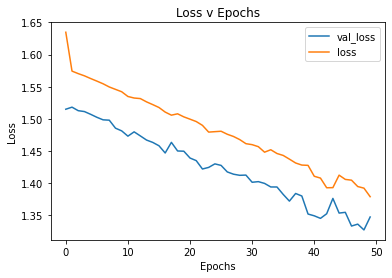

In [35]:
visualize_results(results4)

### Insight: the curve variablity has slightly improved. Will reduce model complexity to reduce the loss function and train the model against the entire training set.

In [36]:
#reducing layers and nodes within layers
np.random.seed(42)

lambda_coeff = 0.005

model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3,3), activation='tanh',
                        input_shape=(64, 64, 1), padding='same'))

model5.add(layers.Flatten())
model5.add(layers.Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
model5.add(layers.Dense(8, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))

model5.add(layers.Dense(1, activation='sigmoid'))

In [37]:
model5.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results5 = model5.fit(X_train, 
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 1s 52ms/step - loss: 0.8238 - recall_4: 0.9482 - acc: 0.7342 - val_loss: 0.7023 - val_recall_4: 1.0000 - val_acc: 0.8101
Epoch 2/50
20/20 [==============================] - 1s 32ms/step - loss: 0.7734 - recall_4: 1.0000 - acc: 0.7642 - val_loss: 0.6981 - val_recall_4: 1.0000 - val_acc: 0.8101
Epoch 3/50
20/20 [==============================] - 1s 31ms/step - loss: 0.7646 - recall_4: 1.0000 - acc: 0.7642 - val_loss: 0.6971 - val_recall_4: 1.0000 - val_acc: 0.8101
Epoch 4/50
20/20 [==============================] - 1s 32ms/step - loss: 0.7600 - recall_4: 1.0000 - acc: 0.7642 - val_loss: 0.6972 - val_recall_4: 1.0000 - val_acc: 0.8101
Epoch 5/50
20/20 [==============================] - 1s 31ms/step - loss: 0.7574 - recall_4: 1.0000 - acc: 0.7642 - val_loss: 0.6975 - val_recall_4: 1.0000 - val_acc: 0.8101
Epoch 6/50
20/20 [==============================] - 1s 31ms/step - loss: 0.7557 - recall_4: 1.0000 - acc: 0.7642 - val_loss: 0.6979 - v

20/20 [==============================] - 1s 31ms/step - loss: 0.7229 - recall_4: 1.0000 - acc: 0.7642 - val_loss: 0.6691 - val_recall_4: 1.0000 - val_acc: 0.8101
Epoch 49/50
20/20 [==============================] - 1s 32ms/step - loss: 0.7223 - recall_4: 1.0000 - acc: 0.7642 - val_loss: 0.6676 - val_recall_4: 1.0000 - val_acc: 0.8101
Epoch 50/50
20/20 [==============================] - 1s 31ms/step - loss: 0.7216 - recall_4: 1.0000 - acc: 0.7642 - val_loss: 0.6668 - val_recall_4: 1.0000 - val_acc: 0.8101


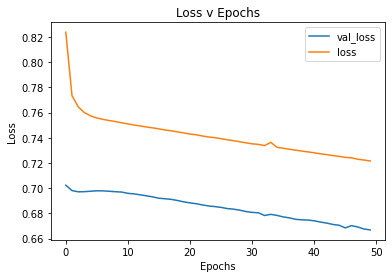

In [38]:
visualize_results(results5)

In [39]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                2097168   
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 2,097,633
Trainable params: 2,097,633
Non-trainable params: 0
_________________________________________________________________


### Insight: while model 5 has much lower variation, the accuracy is not good. From here, we will attempt to reduce the complexity of the model by implementing dropout regularization as well.

#### Dropout regularization tests to reduce complexity

In [40]:
np.random.seed(42)

model6 = models.Sequential()
model6.add(layers.Conv2D(32, (3,3), activation='tanh',
                        input_shape=(64, 64, 1)))

model6.add(layers.Flatten())
model6.add(layers.Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
model6.add(layers.Dropout(0.3))
model6.add(layers.Dense(8, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
model6.add(layers.Dropout(0.3))
model6.add(layers.Dense(1, activation='sigmoid'))

In [41]:
model6.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results6 = model6.fit(X_train, 
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 1s 42ms/step - loss: 0.8373 - recall_5: 0.8468 - acc: 0.6930 - val_loss: 0.7060 - val_recall_5: 1.0000 - val_acc: 0.8101
Epoch 2/50
20/20 [==============================] - 1s 29ms/step - loss: 0.8588 - recall_5: 0.8923 - acc: 0.7009 - val_loss: 0.7027 - val_recall_5: 1.0000 - val_acc: 0.8101
Epoch 3/50
20/20 [==============================] - 1s 29ms/step - loss: 0.8439 - recall_5: 0.8861 - acc: 0.7057 - val_loss: 0.7018 - val_recall_5: 1.0000 - val_acc: 0.8101
Epoch 4/50
20/20 [==============================] - 1s 30ms/step - loss: 0.8358 - recall_5: 0.8944 - acc: 0.6978 - val_loss: 0.6992 - val_recall_5: 1.0000 - val_acc: 0.8101
Epoch 5/50
20/20 [==============================] - 1s 30ms/step - loss: 0.8158 - recall_5: 0.9006 - acc: 0.7184 - val_loss: 0.6980 - val_recall_5: 1.0000 - val_acc: 0.8101
Epoch 6/50
20/20 [==============================] - 1s 29ms/step - loss: 0.8169 - recall_5: 0.9172 - acc: 0.7199 - val_loss: 0.6974 - v

20/20 [==============================] - 1s 29ms/step - loss: 0.7662 - recall_5: 0.9814 - acc: 0.7563 - val_loss: 0.6616 - val_recall_5: 1.0000 - val_acc: 0.8101
Epoch 49/50
20/20 [==============================] - 1s 28ms/step - loss: 0.7501 - recall_5: 0.9917 - acc: 0.7642 - val_loss: 0.6610 - val_recall_5: 1.0000 - val_acc: 0.8101
Epoch 50/50
20/20 [==============================] - 1s 29ms/step - loss: 0.7497 - recall_5: 0.9814 - acc: 0.7532 - val_loss: 0.6604 - val_recall_5: 1.0000 - val_acc: 0.8101


In [42]:
results_train6 = model6.evaluate(X_train, y_train)

20/20 [==============================] - 0s 11ms/step - loss: 0.7239 - recall_5: 1.0000 - acc: 0.7642


In [43]:
results_val6 = model6.evaluate(X_val, y_val)

5/5 [==============================] - 0s 8ms/step - loss: 0.6604 - recall_5: 1.0000 - acc: 0.8101


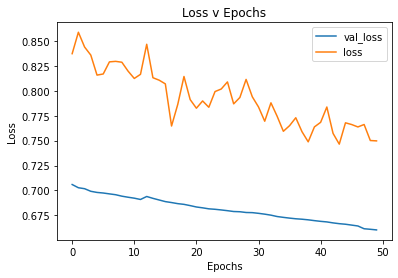

In [44]:
visualize_results(results6)

#### dropout drastically reduces variance of the validation set, but the testing set variance is still very high. The recall value of 1 indicates there is still overfitting.  Will introduce padding parameter to improve loss values.

In [45]:
#introducing padding
np.random.seed(42)
model7 = models.Sequential()
model7.add(layers.Conv2D(32, (3,3), activation='tanh',
                        input_shape=(64, 64, 1), padding='same'))

model7.add(layers.Flatten())
model7.add(layers.Dense(42, activation='tanh'))
model7.add(layers.Dropout(0.3))
model7.add(layers.Dense(21, activation='tanh'))
model7.add(layers.Dropout(0.3))
model7.add(layers.Dense(1, activation='sigmoid'))

In [46]:
model7.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results7 = model7.fit(X_train, 
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 1s 48ms/step - loss: 0.7083 - recall_6: 0.6874 - acc: 0.5918 - val_loss: 0.4929 - val_recall_6: 1.0000 - val_acc: 0.8101
Epoch 2/50
20/20 [==============================] - 1s 37ms/step - loss: 0.6175 - recall_6: 0.9151 - acc: 0.7215 - val_loss: 0.4882 - val_recall_6: 1.0000 - val_acc: 0.8101
Epoch 3/50
20/20 [==============================] - 1s 36ms/step - loss: 0.6281 - recall_6: 0.8986 - acc: 0.7041 - val_loss: 0.4862 - val_recall_6: 1.0000 - val_acc: 0.8101
Epoch 4/50
20/20 [==============================] - 1s 37ms/step - loss: 0.5961 - recall_6: 0.9296 - acc: 0.7294 - val_loss: 0.4860 - val_recall_6: 1.0000 - val_acc: 0.8101
Epoch 5/50
20/20 [==============================] - 1s 37ms/step - loss: 0.6090 - recall_6: 0.9130 - acc: 0.7120 - val_loss: 0.4860 - val_recall_6: 1.0000 - val_acc: 0.8101
Epoch 6/50
20/20 [==============================] - 1s 37ms/step - loss: 0.5775 - recall_6: 0.9482 - acc: 0.7310 - val_loss: 0.4862 - v

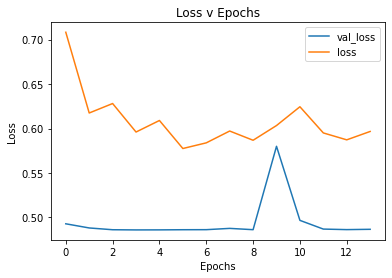

In [47]:
visualize_results(results7)

#### Insight: while the variation of the validation set is minimial, the accuracy of the model is still too low. From here, we will generate predictions with the best performing model.

### Predictions with model 4, which has the highest accuracy and lowest variation in the validation set despite being overfit.

In [48]:
#generate predictions, evaluate probabilities as 0 or 1
label_pred = (model4.predict(X_val) > 0.5).astype(int)

cf_matrix = confusion_matrix(y_val, label_pred)

In [49]:
label_pred

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

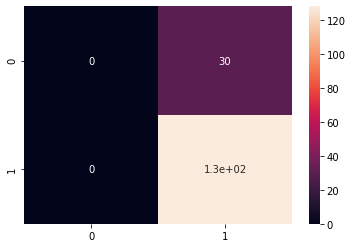

In [50]:
#plot confusion matrix

sns.heatmap(cf_matrix, annot=True);

## Summary 

#### tanh doesn't seem to be a suitable activation function for image prediction in this model. All the models are prone to overfitting, and the accuracy values, while consistent between the training and validation sets, are consistently low. Accurately predicting pneumonia diagnosis is a high stakes prediction, and low accuracy values have consequences for individuals after deployment. Our final model will use the ReLu activation function, as it is consistently better performing than other activation functions.